# Case study of uniaxial tensile tests

This is an example of how to use Paramaterial to process a dataset of uniaxial tensile test measurements.
The data should be formatted as a set of csv files containing measurements for each test, and a single excel spreadsheet containing the metadata for the dataset.
There should be a single row in the excel spreadsheet for each csv file.

The analysis takes 4 stages:
- Data preparation
- Data processing
- Model fitting
- Test report generation

## Modelling
We determine the material properties and fit a model to the transition region, following the process explained in the paper:

"Starting from a preload (which was chosen to be 30 lbf to minimize errors in the strain measurements caused by factors such as initial grip alignment), the upper proportional limit (UPL) is determined by linear regression as the point that minimizes the residuals of the slope fit between that point and the preload.

Then, starting from this UPL, the procedure was repeated in the opposite direction to obtain the lower proportional limit (LPL).

This procedure is automated and the proportional limits are consistently identified for all stress-strain curves using this criteria.

The elastic modulus is calculated as the slope of the best fit straight line between the upper and lower proportional limits.

Foot correction is applied to the stress-strain curve such that the linear elastic portion of the curve begins at the origin.

The 0.2% proof stress is then determined using this slope with an offset of 0.2% strain and is recorded as the yield stress and the corresponding strain is noted as the strain at yield.

From the upper proportional limit to the yield point, the Ramberg-Osgood model is fit to the data, and the fit parameter n is estimated by regression."

30 lbf of force is equivalent to 133.5 Newtons.

In [1]:
import os
import shutil
from typing import Callable

import numpy as np
from matplotlib import pyplot as plt

import paramaterial as pam
from paramaterial.plug import DataSet, DataItem

Input data.

In [2]:
processed_set = DataSet('data/02 processed data', 'info/02 processed info.xlsx').sort_by(['temperature', 'lot'])

Setup plotting.

In [3]:
styler = pam.plotting.Styler(color_by='temperature', cmap='plasma', color_by_label='(°C)', plot_kwargs=dict(grid=True))
styler.style_to(processed_set)


def ds_plot(ds: DataSet, **kwargs):
    return pam.plotting.dataset_plot(ds, styler=styler, **kwargs)


subplot_cfg = dict(
    shape=(3, 3), sharex='all', sharey='all', hspace=0.2,
    rows_by='lot', row_vals=[[a] for a in 'ABCDEFGHI'],
    cols_by='lot', col_vals=[[a] for a in 'ABCDEFGHI'],
    plot_titles=[f'Lot {a}' for a in 'ABCDEFGHI']
)


def ds_subplots(ds: DataSet, **kwargs):
    return pam.plotting.dataset_subplots(ds=ds, styler=styler, plot_legend=False, **subplot_cfg, **kwargs)


def subplot_wrapper(ds: DataSet, plot_func: Callable[[DataItem], DataItem], **plot_func_kwargs):
    return pam.plotting.subplot_wrapper(ds=ds, plot_func=plot_func, **subplot_cfg, **plot_func_kwargs)


stress_strain_labels = dict(x='Strain', y='Stress_MPa', ylabel='Stress (MPa)')

Plot input data.

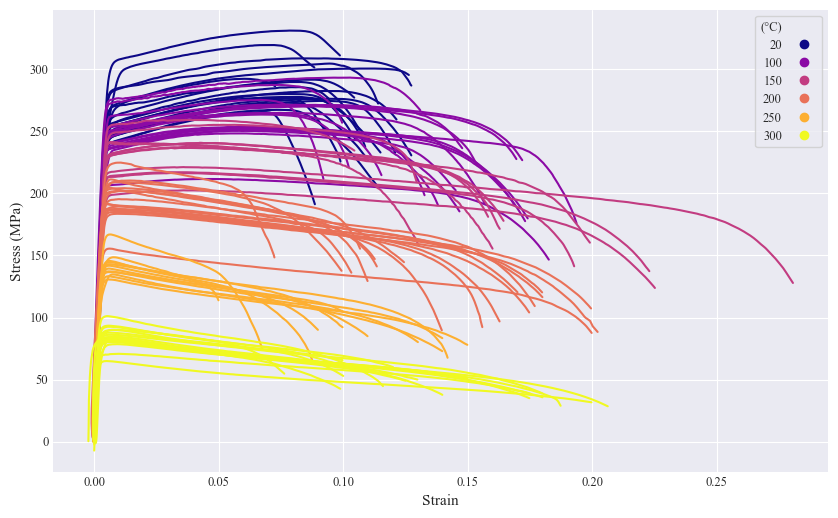

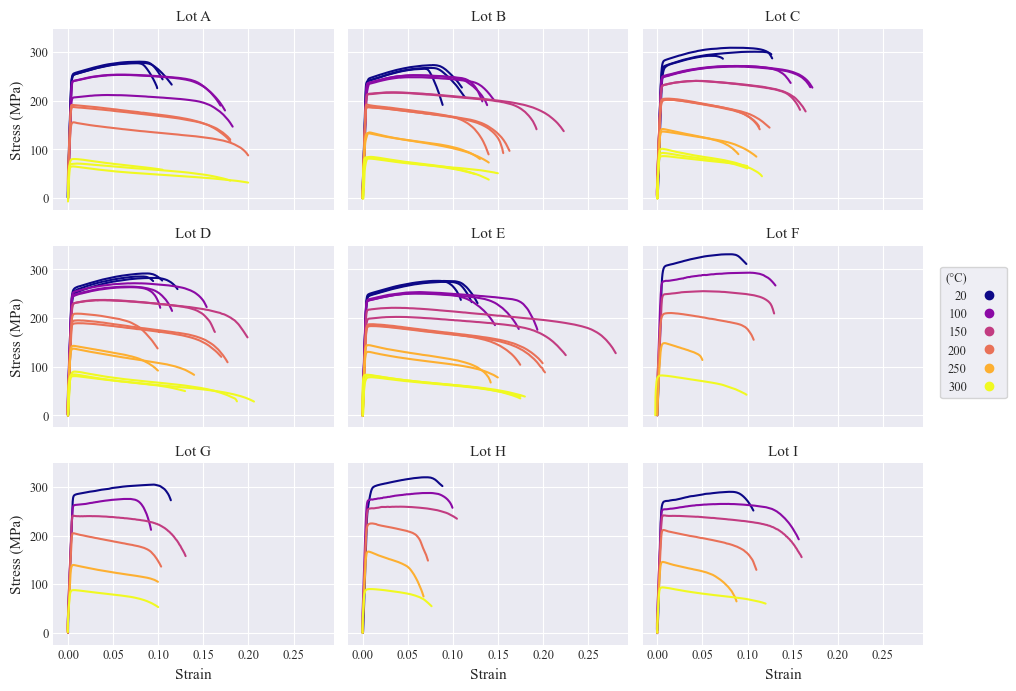

In [4]:
ds_plot(processed_set, **stress_strain_labels);
ds_subplots(processed_set, **stress_strain_labels);

### Trim to small-strain region

In [5]:
def trim(di):
    di.data = di.data[di.data['Strain'] < 0.01]
    return di


trimmed_set = processed_set.apply(trim)

### Find proportional limits and elastic modulus

In [6]:
trimmed_set = trimmed_set.apply(pam.modelling.determine_proportional_limits_and_elastic_modulus, preload=36,
                                suppress_numpy_warnings=True)
trimmed_set.write_output('data/02 trimmed small data', 'info/02 trimmed small info.xlsx')

Plot proportional limits.

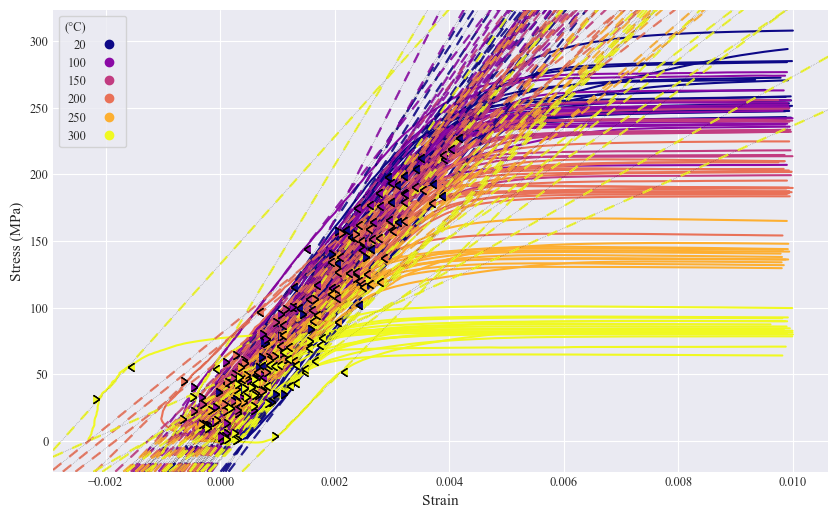

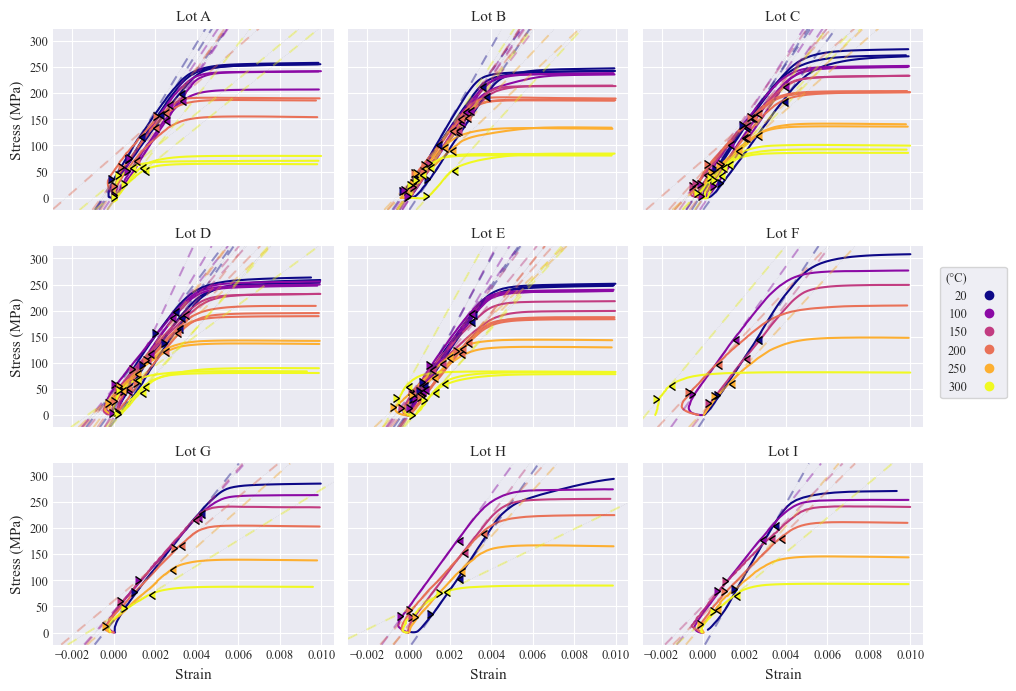

In [17]:
trimmed_ds = DataSet('data/02 trimmed small data', 'info/02 trimmed small info.xlsx')


def plot_upl_and_lpl(di, ax):
    temp = di.info['temperature']
    color = styler.color_dict[temp]
    ax.axline((di.info['UPL_0'], di.info['UPL_1']), slope=di.info['E'], c=color, ls=(0, (5, 5)), alpha=0.4, zorder=500 + temp)
    ax.axline((di.info['UPL_0'], di.info['UPL_1']), slope=di.info['E'], lw=0.5, ls=':', c='k', alpha=0.1, zorder=500 + temp)
    ax.plot(di.info['UPL_0'], di.info['UPL_1'], c='k', mfc=color, marker=4, markersize=6, zorder=1000 + temp)
    ax.plot(di.info['LPL_0'], di.info['LPL_1'], c='k', mfc=color, marker=5, markersize=6, zorder=1000 + temp)
    return di


ax = ds_plot(trimmed_ds, **stress_strain_labels)
list(trimmed_ds.apply(plot_upl_and_lpl, ax=ax));
axs = ds_subplots(trimmed_ds, **stress_strain_labels)
subplot_wrapper(trimmed_ds, plot_upl_and_lpl, axs=axs);

### Apply foot correction

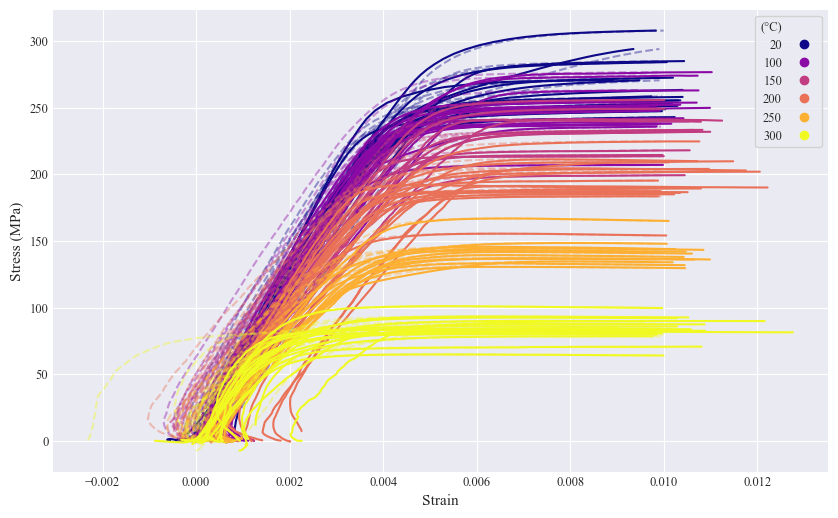

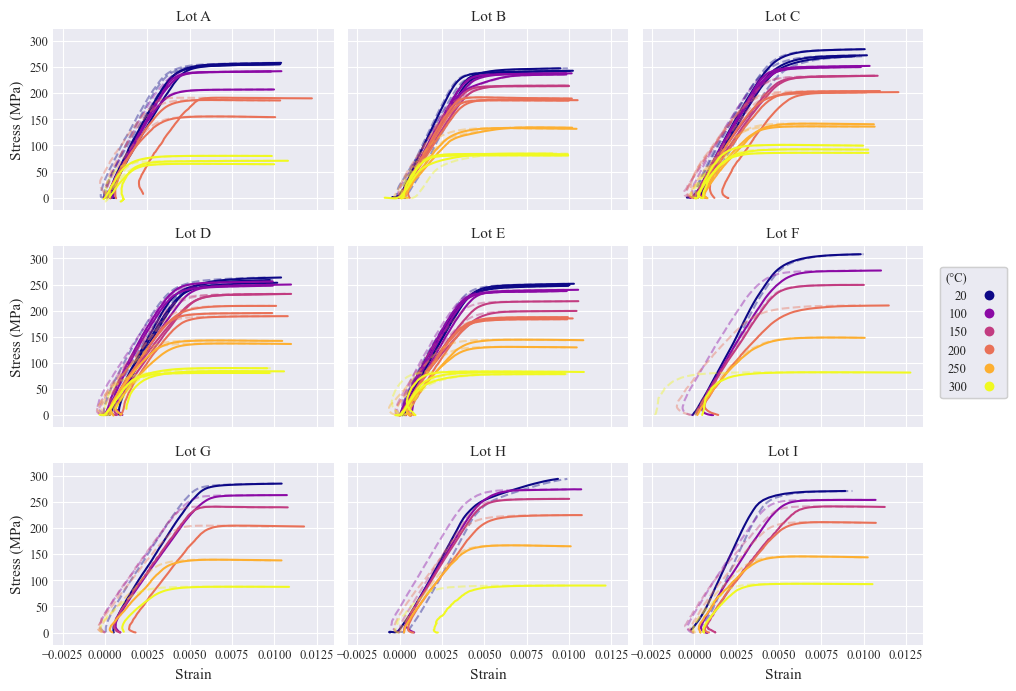

In [8]:
def foot_correction(di):
    E = di.info['E']
    UPL = di.info['UPL_0'], di.info['UPL_1']
    strain_shift = UPL[0] - UPL[1]/E  # x-intercept of line through UPL & LPL
    di.info['foot correction'] = strain_shift
    di.data['Strain'] = di.data['Strain'].values - strain_shift
    di.info['UPL_0'], di.info['UPL_1'] = di.info['UPL_0'] - strain_shift, di.info['UPL_1'] - strain_shift
    di.info['LPL_0'], di.info['LPL_1'] = di.info['LPL_0'] - strain_shift, di.info['LPL_1'] - strain_shift
    return di

# apply foot correction to dataset
foot_set = trimmed_ds.apply(foot_correction)

# visualise
ax = ds_plot(trimmed_ds, **stress_strain_labels, alpha=0.4, ls='--')
ds_plot(foot_set, **stress_strain_labels, ax=ax);
axs = ds_subplots(trimmed_ds, **stress_strain_labels, alpha=0.4, ls='--')
ds_subplots(foot_set, **stress_strain_labels, axs=axs);

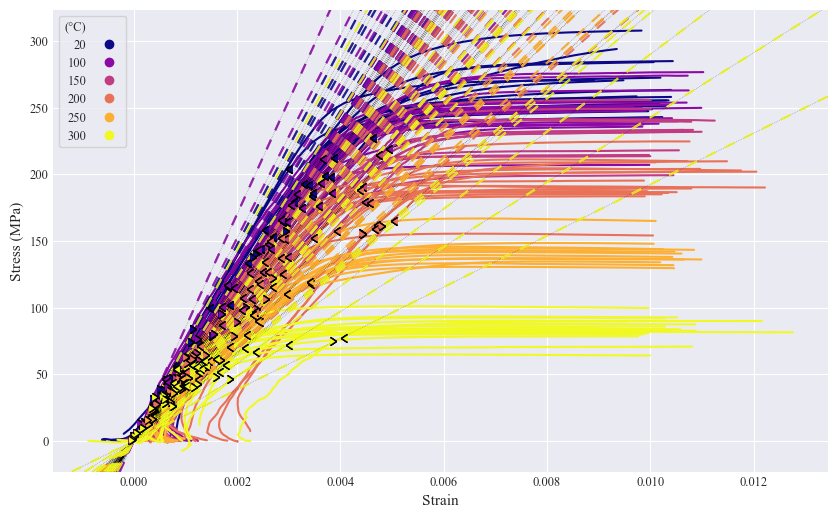

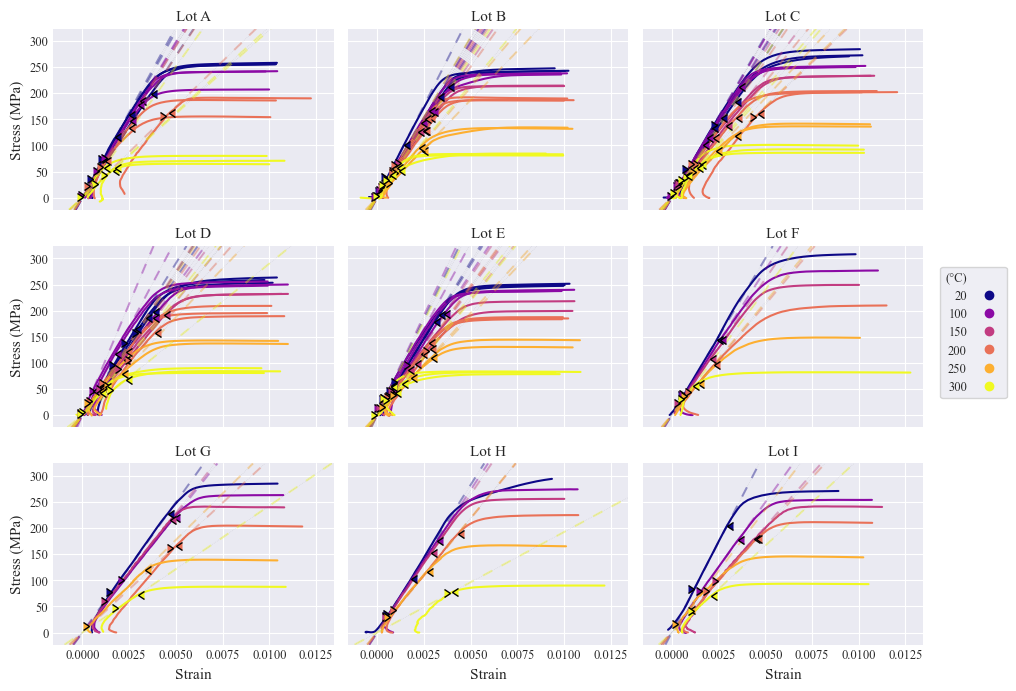

In [11]:
foot_set.write_output('data/02 foot corrected data', 'info/02 foot corrected info.xlsx')
foot_ds = DataSet('data/02 foot corrected data', 'info/02 foot corrected info.xlsx')
ax = ds_plot(foot_ds, **stress_strain_labels)
list(foot_ds.apply(plot_upl_and_lpl, ax=ax));
axs = ds_subplots(foot_ds, **stress_strain_labels)
subplot_wrapper(foot_ds, plot_upl_and_lpl, axs=axs);

### Run screening for foot correction

Set up screening plot.

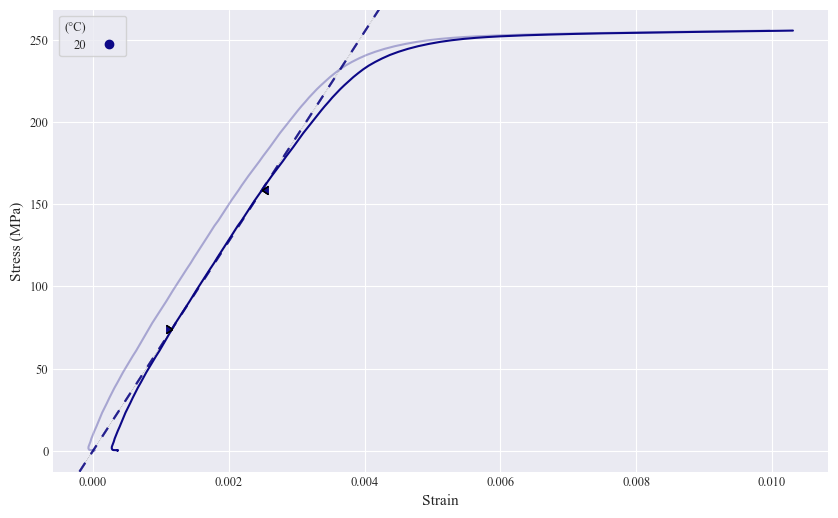

In [18]:
def screening_plot(di):
    test_id = di.test_id
    ax = ds_plot(trimmed_ds[{'test id': [test_id]}], **stress_strain_labels, alpha=0.3)
    ds_plot(foot_ds[{'test id': [test_id]}], **stress_strain_labels, ax=ax)
    list(foot_ds[{'test id': [test_id]}].apply(plot_upl_and_lpl, ax=ax))
    return None

screening_plot(foot_ds[0])

Make screening pdf.

In [19]:
pam.processing.make_screening_pdf(foot_ds, screening_plot, 'info/foot correction screening.pdf')

0DataItems [00:00, ?DataItems/s]
0DataItems [00:00, ?DataItems/s]
                                
0DataItems [00:00, ?DataItems/s]
                                
0DataItems [00:00, ?DataItems/s]
1DataItems [00:02,  2.07s/DataItems]
0DataItems [00:00, ?DataItems/s]
                                
0DataItems [00:00, ?DataItems/s]
                                
0DataItems [00:00, ?DataItems/s]
2DataItems [00:04,  2.04s/DataItems]
0DataItems [00:00, ?DataItems/s]
                                
0DataItems [00:00, ?DataItems/s]
                                
0DataItems [00:00, ?DataItems/s]
3DataItems [00:06,  2.02s/DataItems]
0DataItems [00:00, ?DataItems/s]
                                
0DataItems [00:00, ?DataItems/s]
                                
0DataItems [00:00, ?DataItems/s]
4DataItems [00:08,  2.02s/DataItems]
0DataItems [00:00, ?DataItems/s]
                                
0DataItems [00:00, ?DataItems/s]
                                
0DataItems [00:00, ?DataIte

Screening pdf saved to info/foot correction screening.pdf.


In [28]:
trimmed_ds = pam.processing.read_screening_pdf_to(trimmed_ds, 'info/foot correction screening marked.pdf')
trimmed_ds.info_table['comment'].value_counts()

             89
LPL @ 100     6
LPL @ 30      4
LPL @ 75      1
Name: comment, dtype: int64

Apply comments.

In [33]:
def comment_function(di):
    if not str(di.info.comment).startswith('LPL'):
        return di
    lpl_stress = float(di.info.comment.split(' ')[-1])
    lpl_strain = np.interp(lpl_stress, di.data['Stress_MPa'], di.data['Strain'])
    di.info['LPL_1'] = lpl_stress
    di.info['LPL_0'] = lpl_strain
    di.info['E'] = (di.info['UPL_1'] - di.info['UPL_0'])/(di.info['LPL_1'] - di.info['LPL_0'])
    return di


trimmed_ds = trimmed_ds.apply(comment_function)
trimmed_ds.write_output('data/02 screened foot data', 'info/02 screened foot info.xlsx')


Redo foot correction.

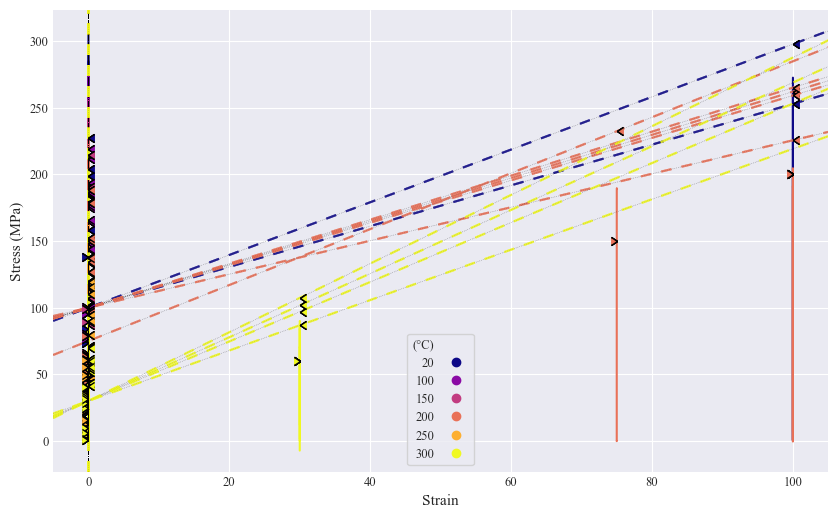

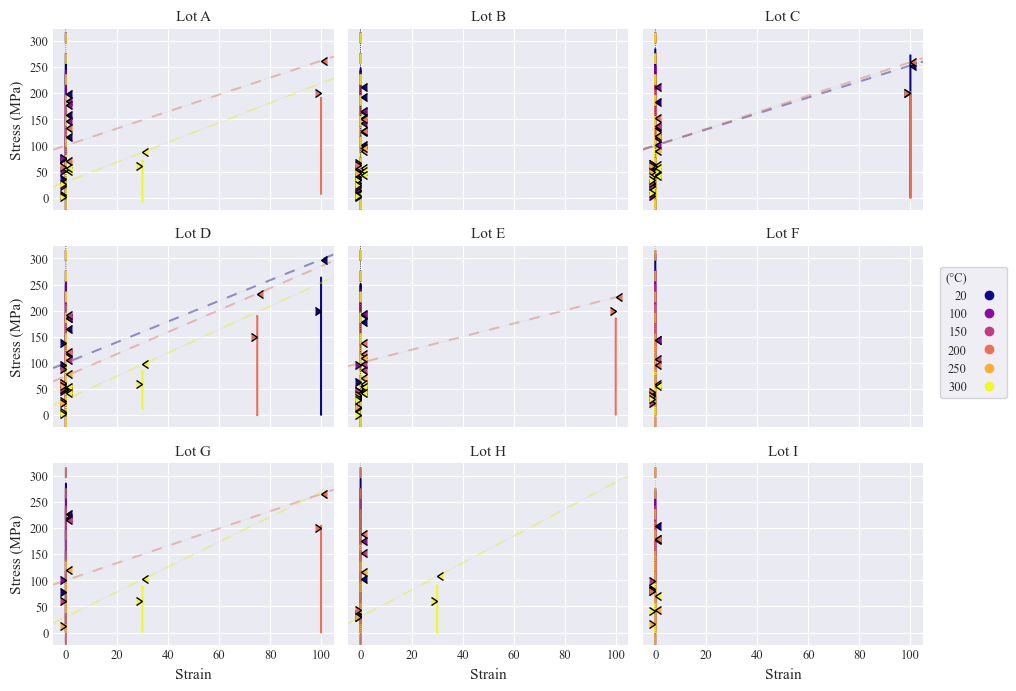

In [34]:
foot_ds = trimmed_ds.apply(foot_correction)

ax = ds_plot(foot_ds, **stress_strain_labels)
list(foot_ds.apply(plot_upl_and_lpl, ax=ax));
axs = ds_subplots(foot_ds, **stress_strain_labels)
subplot_wrapper(foot_ds, plot_upl_and_lpl, axs=axs);

### Find proof stress